In [1]:

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    ShuffleSplit,
    learning_curve
)
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    classification_report
)
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet(r"../data/types_fixed_german_credit_data.parquet", engine="pyarrow")

Based on the heuristics proposed in the EDA only 4 columns are needed: **Credit amount, Purpose, Saving accounts and Housing**.

In [3]:
selected_features = ["Risk", "Credit amount", "Purpose", "Saving accounts", "Housing"]

df = df[selected_features]
df = df.dropna(subset=["Risk"])  # Got to drop all rows where Risk is NAN. To stratify latter target var can not have missing values.
df["Risk"] = df["Risk"].map({"good": 1, "bad": 0}).astype("int8")

As encountered in the previous EDA, housing, sex and purpose features had some weird, probably tampered, values in them, let's ditch those.

In [4]:
weird_categories = {
    "Housing" : ["356", "43", "563"],
    #"Sex" : ["353546"],
    "Purpose" : ["3", "356", "56", "6"]
}

for col, values in weird_categories.items():
    df[col] = df[col].replace(values, np.nan)

**Feature Engineering**

In [5]:
num_cols = ["Credit amount"]
cat_cols = ["Purpose", "Housing"]
cat_ord_cols = ["Saving accounts"]

In [6]:
def outliers_feature_names(_, feature_names) -> np.ndarray:
    return feature_names

def remove_outliers(X: pd.DataFrame, threshold: float = 1.5) -> pd.DataFrame:
    """
    Replace outliers from numeric columns given a certain treshold with NAN.
    Args:
        threshold (float, optional): Treshold for removing minor (1.5) or extreme outliers (3.0). Defaults to 1.5.
    """
    assert isinstance(X, pd.DataFrame)
    assert 1.5 <= threshold <= 3.0
    Q1, Q3 = X.quantile(0.25), X.quantile(0.75)
    IQR: float = Q3 - Q1
    mask: function = ~((X >= (Q1 - threshold * IQR)) & (X <= (Q3 + threshold * IQR))).all(axis=1)
    X.loc[mask] = np.nan
    return X

In [7]:
numeric_pipe = Pipeline(
    steps=[
        ("outlier removal", FunctionTransformer(
            remove_outliers,
            kw_args={'threshold': 3.0}, 
            feature_names_out=outliers_feature_names
        )),
        ("imputer", KNNImputer(n_neighbors=5))
    ]
)

cat_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ]
)

cat_ord_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ]
)

ordinal_transformers = [(f"{col}_ordinal", "passthrough", [col]) for col in cat_ord_cols]


preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipe, num_cols),
        ("categoric", "passthrough", cat_cols),
    ] + ordinal_transformers
)

In [8]:
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('outlier removal',
                                                  FunctionTransformer(feature_names_out=<function outliers_feature_names at 0x0000016FA6B9B560>,
                                                                      func=<function remove_outliers at 0x0000016FDA6E4D60>,
                                                                      kw_args={'threshold': 3.0})),
                                                 ('imputer', KNNImputer())]),
                                 ['Credit amount']),
                                ('categoric', 'passthrough',
                                 ['Purpose', 'Housing']),
                                ('Saving accounts_ordinal', 'passthrough',
                                 ['Saving accounts'])])

In [9]:
X_features = df.drop(columns=["Risk"])
Y_target = df["Risk"]

x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, stratify= Y_target
)

**Heuristic based model**

In [10]:
class HeuristicModel(BaseEstimator, ClassifierMixin):
    def fit(self, _, y=None):
        if y is not None:
            self.classes_ = np.unique(y)
        return self
    
    def predict(self, X) -> np.ndarray:
        assert all(len(input) == 4 for input in X), "Not all inputs have length 4"
        
        HOUSING = "own",  # x[0]
        CREDIT_AMOUNT_THRESHOLD_HIGH = 3900  # x[1]
        PURPOSE_1, PURPOSE_2 = "radio/TV", "car"  #x[2]
        SAVING_ACCOUNTS = "little"  # x[3]
        asses_risk = lambda x: 1 if (x[0] == HOUSING and x[1] <= CREDIT_AMOUNT_THRESHOLD_HIGH) or (x[2] == PURPOSE_1 or x[2] == PURPOSE_2) or (x[3] != SAVING_ACCOUNTS) else 0
        predictions = [asses_risk(input) for input in X]
        return np.array(predictions)

accuracy - CV mean: 0.5347980980867995, CV std: 0.027115856746256353
accuracy - Train score: 0.5348034006376196
f1 - CV mean: 0.5840507574669773, CV std: 0.03124248210484267
f1 - Train score: 0.5348034006376196
precision - CV mean: 0.7778166120251212, CV std: 0.02172489389372044
precision - Train score: 0.5348034006376196
recall - CV mean: 0.4680939624380689, CV std: 0.03454217631518548
recall - Train score: 0.5348034006376196


<Axes: title={'center': 'Cross Validation Boxplot'}, ylabel='Score'>

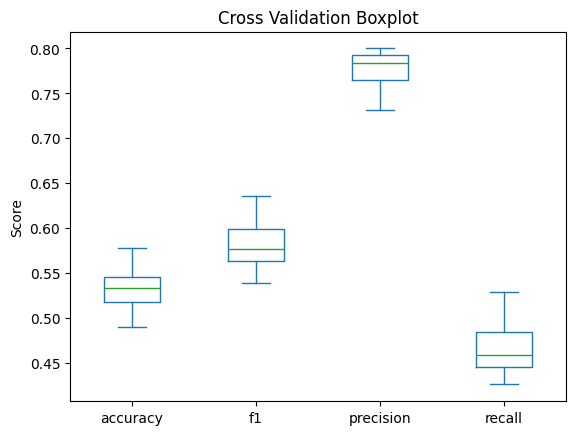

In [11]:
model = HeuristicModel()
scoring_metrics = ["accuracy", "f1", "precision", "recall"]
fold = StratifiedKFold(n_splits=10)  # better for classification, mantains classes proportion in each fold
model_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

cv_results = {}
train_results = {}

for metric in scoring_metrics:
    cv_results[metric] = cross_val_score(
        model_pipe, x_train, y_train, cv=fold, scoring=metric
    )
    # Evaluate on the training set
    model_pipe.fit(x_train, y_train)
    train_results[metric] = model_pipe.score(x_train, y_train)

# Convert results into a pandas DataFrame
cv_results_df = pd.DataFrame(cv_results)

for metric_name in scoring_metrics:
    print(
        f"{metric_name} - CV mean: {cv_results_df[metric_name].mean()}, "
        f"CV std: {cv_results_df[metric_name].std()}"
    )
    print(f"{metric_name} - Train score: {train_results[metric_name]}")

# Create a boxplot for the cross-validation results of each metric
cv_results_df.plot.box(title="Cross Validation Boxplot", ylabel="Score")

<Axes: title={'center': 'Training vs Cross-Validation Scores'}, xlabel='Metric', ylabel='Score'>

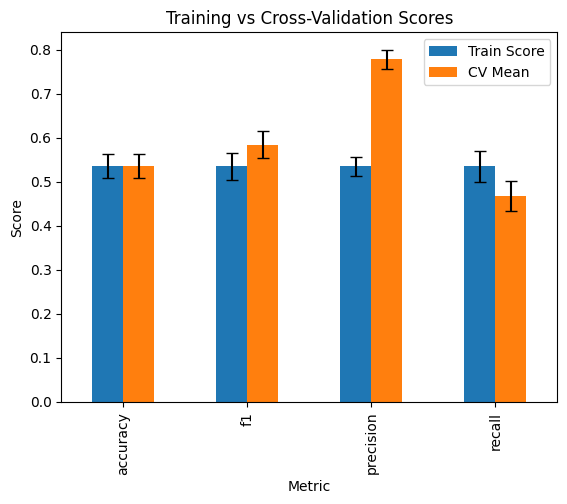

In [12]:
metrics_df = pd.DataFrame(
    {
        "Metric": scoring_metrics,
        "Train Score": [train_results[metric] for metric in scoring_metrics],
        "CV Mean": [cv_results_df[metric].mean() for metric in scoring_metrics],
        "CV Std": [cv_results_df[metric].std() for metric in scoring_metrics],
    }
)

# Create a bar plot for the training and cross-validation metrics
metrics_df.plot(
    kind="bar",
    x="Metric",
    y=["Train Score", "CV Mean"],
    yerr="CV Std",
    title="Training vs Cross-Validation Scores",
    ylabel="Score",
    capsize=4,
)

**Analysis of the results of all metrics**
1. Accuracy
   - Cross validation mean: 
   - Cross validation std: 
   - Train score: 
   - Interpretation: The accuracy on the training set is very close to the cross-validation mean accuracy, with a decimal difference. The standard deviation indicates slight variability in accuracy across different folds.
2. F1 score
   - Cross validation mean: 
   - Cross validation std: 
   - Train score: 
   - Interpretation: The F1 score is lower on the training set than the cross-validation mean F1 score. The standard deviation indicates moderate variability in F1 score across different folds.
3. Precision
   - Cross validation mean: 
   - Cross validation std:
   - Train score: 
   - Interpretation: The precision is much lower on the training set than the cross-validation mean precision score. The standard deviation indicates moderate variability in precision score across different folds.
4. Recall
   - Cross validation mean: 
   - Cross validation std:
   - Train score: 
   - Interpretation: The recall score on the training set is significantly higher than the cross-validation mean recall score. The standard deviation indicates moderate variability in recall score across different folds.

**Conlusion:**
The difference between training and testing performance occurs because the heuristic model is not complex enough to capture data relationships during training but performs slightly better during testing.

To understand this further, we need to examine how K-Fold cross-validation works. This technique divides the dataset into n partitions (folds). In each iteration, the model is trained on n-1 folds and tested on the remaining fold. This process repeats n times, ensuring that every data point is used for both training and testing.

If the model lacks complexity, it is not surprising to see better performance on the cross-validation set than on the training set. This happens because the training set is larger and contains more diverse patterns, making it harder for the model to generalize.

**Final evaluation**

In [13]:
y_pred = model_pipe.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.36      0.69      0.47       283
           1       0.78      0.47      0.59       658

    accuracy                           0.54       941
   macro avg       0.57      0.58      0.53       941
weighted avg       0.65      0.54      0.55       941



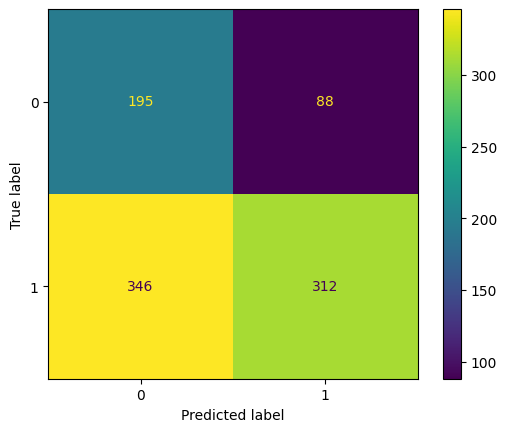

In [14]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

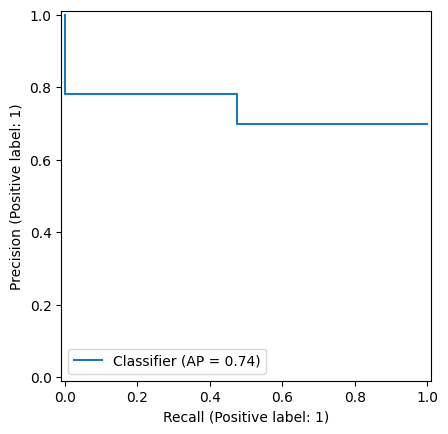

In [15]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred)

- Curve has an abrupt drop down, which means the model loses precision when recall augmentates.

In [16]:
df["Credit amount"]

0       3632
1       2603
2        902
3        654
4       3414
        ... 
4841    4771
4842    3485
4843    3069
4844    1200
4845     590
Name: Credit amount, Length: 4705, dtype: Int64

**Only one metric (Precision)**
Precision is the chosen metric for this credit risk model because it is more important to ensure that approved credits are truly good, minimizing the risk of granting loans to bad creditors.

The objective of this model is to correctly identify good credit applicants while avoiding false approvals of bad credits. Hypothetically, the model is going to be used to approve loans with minimal risk, so precision is the most important metric for this model.

Precision is crucial because it measures the model’s ability to correctly classify applicants as good credit risks. In situations where the cost of approving a bad credit (False Positive, FP) is high—leading to financial losses and increased default rates—it is more important to ensure that approved loans are truly reliable, even if it means rejecting some potentially good applicants.

The False Positive (FP) is the most critical error in this case, as approving a bad credit applicant can result in financial losses. By prioritizing precision, the model ensures that only the most trustworthy applicants are approved, reducing the risk of defaults and improving overall loan portfolio quality.

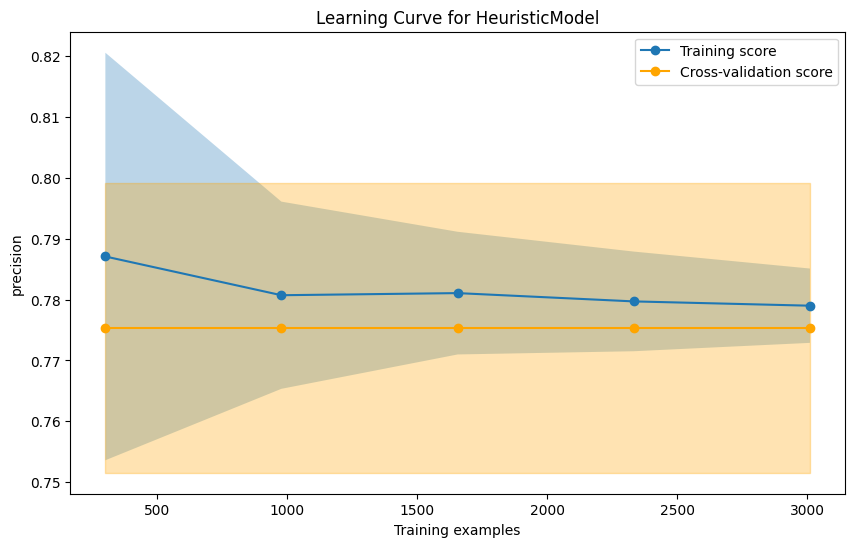

Training Sizes: [ 301  978 1656 2333 3011]
Training Scores Mean: [0.78707665 0.78071212 0.7810593  0.77969726 0.77899119]
Training Scores Std: [0.03347954 0.01537744 0.0100779  0.00818812 0.00610586]
Test Scores Mean: [0.77532351 0.77532351 0.77532351 0.77532351 0.77532351]
Test Scores Std: [0.02377556 0.02377556 0.02377556 0.02377556 0.02377556]


In [17]:
# Define pipeline = preprocessor + model
model = HeuristicModel()
model_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

# Parameters for the learning curve
common_params = {
    "X": x_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=123),
    "n_jobs": -1,
    "return_times": True,
}

scoring_metric = "precision"

# Obtain the learning curve values including fit and score times
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    model_pipe, **common_params, scoring=scoring_metric
)

# Calculate the mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Calculate the mean and standard deviation of the fit and score times
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)
score_times_mean = np.mean(score_times, axis=1)
score_times_std = np.std(score_times, axis=1)

# Plot the learning curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)
ax.plot(train_sizes, train_mean, "o-", label="Training score")
ax.plot(train_sizes, test_mean, "o-", color="orange", label="Cross-validation score")
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
ax.fill_between(
    train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3, color="orange"
)

# Configure the title and labels
ax.set_title(f"Learning Curve for {model.__class__.__name__}")
ax.set_xlabel("Training examples")
ax.set_ylabel(scoring_metric)
ax.legend(loc="best")

# Show the plot
plt.show()

# Print the values for analysis
print("Training Sizes:", train_sizes)
print("Training Scores Mean:", train_mean)
print("Training Scores Std:", train_std)
print("Test Scores Mean:", test_mean)
print("Test Scores Std:", test_std)

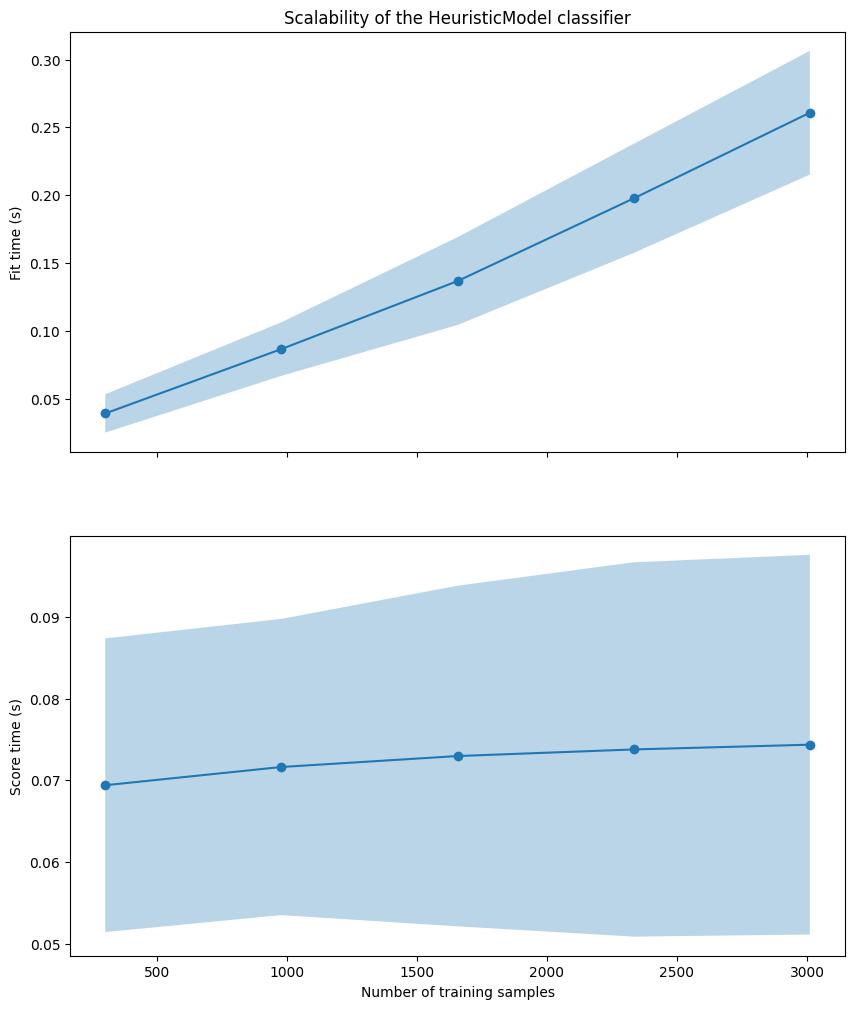

Fit Times Mean: [0.03903631 0.08647683 0.13663962 0.19754554 0.26079245]
Fit Times Std: [0.01414212 0.0197596  0.03237013 0.04025578 0.04564109]
Score Times Mean: [0.06940697 0.07163462 0.0729755  0.0737828  0.07436644]
Score Times Std: [0.01797032 0.01812232 0.02083976 0.02290342 0.02323365]


In [18]:
# Plot the scalability regarding fit time and score time
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

# Scalability regarding the fit time
ax[0].plot(train_sizes, fit_times_mean, "o-")
ax[0].fill_between(
    train_sizes,
    fit_times_mean - fit_times_std,
    fit_times_mean + fit_times_std,
    alpha=0.3,
)
ax[0].set_ylabel("Fit time (s)")
ax[0].set_title(f"Scalability of the {model.__class__.__name__} classifier")

# Scalability regarding the score time
ax[1].plot(train_sizes, score_times_mean, "o-")
ax[1].fill_between(
    train_sizes,
    score_times_mean - score_times_std,
    score_times_mean + score_times_std,
    alpha=0.3,
)
ax[1].set_ylabel("Score time (s)")
ax[1].set_xlabel("Number of training samples")

# Show the plot
plt.show()

# Print the fit and score times for analysis
print("Fit Times Mean:", fit_times_mean)
print("Fit Times Std:", fit_times_std)
print("Score Times Mean:", score_times_mean)
print("Score Times Std:", score_times_std)
